In [1]:
from __future__ import print_function, division
import os
import sys
import re
import pdb
import time

import numpy as np
import scipy as sp
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('tf ', tf.__version__)

sys_version 3.5.2 (default, Nov 17 2016, 17:05:23) [GCC 5.4.0 20160609]
virtual_env None
pwd /home/marko/Projects/faks/NN_face_recognition/nn_devel
np  1.11.1
tf  0.10.0


In [2]:
def square_distance(x, y):
    """
    Computes the squared euclidian distance between two tensorflow variables
    """
    return tf.reduce_sum(tf.square(tf.sub(x, y)), 1)

def triplet_loss(anchor, positive, negative, alpha=0.2):
    """Calculate the triplet loss according to the FaceNet paper
    
    Args:
      anchor: the embeddings for the anchor images.
      positive: the embeddings for the positive images.
      negative: the embeddings for the negative images.
  
    Returns:
      the triplet loss according to the FaceNet paper as a float tensor.
    """
    with tf.variable_scope('triplet_loss'):
        pos_dist = square_distance(anchor, positive)
        neg_dist = square_distance(anchor, negative)
        
        basic_loss = tf.maximum(0.0, pos_dist - neg_dist + alpha)
        loss = tf.reduce_mean(basic_loss, 0)
    return loss

def decov_loss(xs):
    """ Deconv loss for layer """
    
    hs = tf.reshape(xs, [int(xs.get_shape()[0]), -1]) # flaten
    means = tf.reduce_mean(hs, 0, True) 
    deltas = tf.expand_dims(hs - means, 2) # B x N x 1
    deltas_batch_transposed = tf.transpose(deltas, perm=[0,2,1])
    
    corr = tf.reduce_mean(tf.batch_matmul(deltas, deltas_batch_transposed, 0))
                          
    corr_frob_sqr = tf.reduce_sum(tf.square(corr))
    corr_diag_sqr = tf.reduce_sum(tf.square(tf.diag_part(corr)))
    loss = 0.5*(corr_frob_sqr - corr_diag_sqr)
    return loss 

def center_loss_old(logits, labels, alfa):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    nrof_features = logits.get_shape()[1]
    centers = tf.get_variable('centers', shape=(nrof_features), dtype=tf.float32,
        initializer=tf.constant_initializer(value=0.0, dtype=tf.float32), trainable=False)
    loss = tf.nn.l2_loss(logits - centers)
    one_hot = tf.one_hot(labels, nrof_features, axis=1, dtype=tf.float32, name='one_hot')
    delta1 = tf.reduce_mean((centers-logits)*one_hot,0)
    delta2 = 1+tf.reduce_mean(one_hot,0)
    centers_delta = delta1 / delta2
    update_centers = tf.assign_add(centers, -alfa*centers_delta)
    return loss, update_centers


def center_loss(logits, labels, alfa):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    # loss
    n_features = logits.get_shape()[1]
    n_samples = logits.get_shape()[0]
    centers = tf.get_variable('centers', shape=(n_features), dtype=tf.float32,
        initializer=tf.constant_initializer(value=0.0, dtype=tf.float32), trainable=False)
    loss = tf.nn.l2_loss(logits - centers)
    
    # update
    one_hot = tf.one_hot(labels, n_features, axis=1, dtype=tf.float32, name='one_hot')
    
    up_sum = tf.reduce_mean((centers-logits)*one_hot, 0)
    down_sum = 1/n_samples + tf.reduce_mean(one_hot, 0)
    centers_delta = up_sum / down_sum
    update_centers = tf.assign_add(centers, -alfa*centers_delta)
    return loss, update_centers



In [3]:

v1 = tf.Variable(tf.random_normal([1,10]))
v2 = tf.Variable(tf.random_normal([1,10]))
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    v1_val, v2_val = sess.run([v1, v2])
    sqr_dist = sess.run(square_distance(v1, v2))
    
    print(sqr_dist)
    print(((v1_val - v2_val) ** 2).sum())

[ 16.69374657]
16.6937


In [4]:
import cv2
from os.path import join, basename
class Person:
    def __init__(self, name, root_dir):
        self.name = name
        self.root_dir = root_dir
        
    def load_paths(self, formats):
        self.paths = []
        for ext in formats:
            self.paths += glob(join(self.root_dir, '*' + ext))
        
        
    def load_imgs(self, formats=['.png']):
        self.load_paths(formats)
        
        self.imgs = []
        for path in self.paths:
            img = cv2.imread(path)
            self.imgs.append(img)
            
        self.imgs = np.array(self.imgs)
            
def load_imgs(paths):
    return np.array([cv2.imread(path) for path in paths])

In [19]:
# load dataset
from glob import glob

root = './facenet/data/aligned_lfw/'
names = os.listdir(root)[:10]

people = [Person(d, join(root, d)) for d in names]
for p in people: p.load_imgs()
    
def create_samples(people):
    Xs = []; ys = []
    
    for i, p in enumerate(people):
        Xs += [p.imgs]
        ys += [i] * len(p.imgs)
    return np.vstack(Xs), np.vstack(ys)

Xs, ys = create_samples(people)

In [20]:
print(Xs.shape, ys.shape)
print(Xs[0].shape)

(11, 96, 96, 3) (11, 1)
(96, 96, 3)


In [21]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



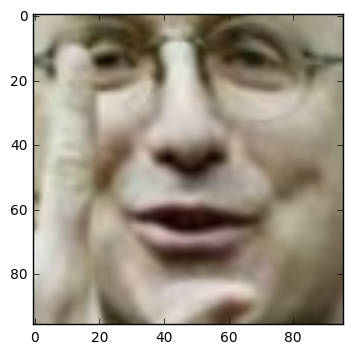

In [22]:
plt.imshow(to_rgb(people[0].imgs[0]))

In [5]:
from tensorflow.python.ops import array_ops
import tensorflow.contrib.layers as layers

def inception(net_in, kernel_stride, o1s, o2s1, o2s2, o3s1, o3s2, o4s1, o4s2, o4s3, name, is_training=True, bn_params={}, weight_decay=0.0, reuse=False):

    net = []
    
    with tf.variable_scope(name):
        with tf.contrib.framework.arg_scope([layers.convolution2d],
                                        padding='SAME', activation_fn=tf.nn.relu,
                                        normalizer_fn=layers.batch_norm, normalizer_params=bn_params,
                                        weights_initializer=layers.xavier_initializer_conv2d(),
                                        weights_regularizer=layers.l2_regularizer(weight_decay), reuse=reuse):
            with tf.variable_scope('branch1_1x1'):
                if o1s > 0:
                    conv1 = layers.convolution2d(net_in, o1s, stride=1, kernel_size=1, scope='conv1x1')
                    net.append(conv1)
                
            with tf.variable_scope('branch2_3x3'):
                if o2s1 > 0:
                    conv3a = layers.convolution2d(net_in, o2s1, stride=1, kernel_size=1, scope='conv1x1')
                    conv3 = layers.convolution2d(conv3a, o2s2, stride=kernel_stride, kernel_size=3, scope='conv3x3')
                    net.append(conv3)

            with tf.variable_scope('branch3_5x5'):
                if o3s1 > 0:
                    conv5a = layers.convolution2d(net_in, o3s1, stride=1, kernel_size=1, scope='conv1x1')
                    conv5 = layers.convolution2d(conv5a, o3s2, stride=kernel_stride, kernel_size=5, scope='conv5x5')
                    net.append(conv5)

            with tf.variable_scope('branch4_pool'):
                pool = layers.max_pool2d(net_in, kernel_size=o4s1, stride=o4s3, padding='SAME', scope='pool')
                if o4s2 > 0:
                    pool = layers.convolution2d(pool, o4s2, stride=1, kernel_size=1, scope='conv1x1')

                net.append(pool)

            incept = array_ops.concat(3, net, name=name)
    return incept

net_out = dict([])
def build_model(inputs, num_classes=128, keep_probability=0.75, is_training=True, reuse=None):
    weight_decay = 1e-3
    bn_params = {
        # Decay for the moving averages.
        'decay': 0.999,
        'center': True,
        'scale': True,
        # epsilon to prevent 0s in variance.
        'epsilon': 0.001,
        # None to force the updates during train_op
        'updates_collections': None,
        'is_training': is_training
    }

    with tf.contrib.framework.arg_scope([layers.convolution2d],
                                        padding='SAME', activation_fn=tf.nn.relu,
                                        normalizer_fn=layers.batch_norm, normalizer_params=bn_params,
                                        weights_initializer=layers.xavier_initializer_conv2d(),
                                        weights_regularizer=layers.l2_regularizer(weight_decay), reuse=reuse):
        net_out['conv1'] = net = layers.convolution2d(inputs, 64, stride=2, kernel_size=7, scope='conv1')
        
        net_out['pool1'] = net = layers.max_pool2d(net, kernel_size=3, stride=2, padding='SAME', scope='pool1')
        net_out['conv2'] = net = layers.convolution2d(net, 64, kernel_size=1, stride=1 ,scope='conv2')
        net_out['conv3'] = net = layers.convolution2d(net, 192, kernel_size=3, stride=1 ,scope='conv3')
        net_out['pool3'] = net = layers.max_pool2d(net, kernel_size=3, stride=2, padding='SAME', scope='pool3')
        
        net_out['incept3a'] = net = inception(net, 1, 64, 96, 128, 16, 32, 3, 32, 1, 'incept3a', is_training, bn_params, weight_decay, reuse)
        net_out['incept3b'] = net = inception(net, 1, 64, 96, 128, 32, 64, 3, 64, 1, 'incept3b', is_training, bn_params, weight_decay, reuse)
        net_out['incept3c'] = net = inception(net, 2, 0, 128, 256, 32, 64, 3, 0, 2,  'incept3c', is_training, bn_params, weight_decay, reuse)

        net_out['incept4a'] = net = inception(net, 1, 256, 96, 192, 32, 64, 3, 128, 1, 'incept4a', is_training, bn_params, weight_decay, reuse)
        net_out['incept4b'] = net = inception(net, 2, 0, 160, 256, 64, 128, 3, 0, 2, 'incept4b', is_training, bn_params, weight_decay, reuse)

        net_out['incept5a'] = net = inception(net, 1, 256, 96,  384, 0, 0, 3, 96,  1, 'incept5a', is_training, bn_params, weight_decay, reuse)
        net_out['incept5b'] = net = inception(net, 1, 256, 96, 384, 0, 0, 3, 96, 1, 'incept5b', is_training, bn_params, weight_decay, reuse)

        net_out['pool6'] = net = layers.avg_pool2d(net, kernel_size=3, stride=2, padding='VALID', scope='pool6')
        net_out['prelogits'] = net = tf.reshape(net, [-1, 736], name='prelogits')
        net = tf.nn.dropout(net, keep_probability)
        net_out['fc7'] = net = layers.fully_connected(net, num_classes, weights_initializer=layers.xavier_initializer(), scope='fc7', reuse=reuse)
        
        net = tf.nn.l2_normalize(net,1,1e-10, name="embeddings")
        return net

In [6]:
class FaceNet:
    def __init__(self):
        """
        :param input_shape: [batch_size, H, W, channels]
        :param num_classes: number of different classes
        """
        self.x = tf.placeholder(tf.float32, [None, 96, 96, 3], name='X')

        self.embeddings = build_model(self.x)
        
        anchor, pos, neg = tf.split(0,3,self.embeddings)
        
        self.triplet_loss = triplet_loss(anchor, pos, neg)
        
        regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.loss = tf.add_n([self.triplet_loss] + regularization_losses, name='loss')

        self.train_op = tf.train.AdamOptimizer().minimize(self.loss)

        self.eval_embeddings = build_model(self.x, 128, 0.75, False, True)
        
        anchor, pos, neg = tf.split(0,3,self.eval_embeddings)
        self.eval_triplet_loss = triplet_loss(anchor, pos, neg)
        regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.eval_loss = tf.add_n([self.eval_triplet_loss] + regularization_losses, name='eval_loss')

        self.session = tf.Session()
        self.session.run(tf.initialize_all_variables())

    def train(self, x):
        run_ops = [self.loss, self.train_op]
        feed_dict = {self.x: x}
        return self.session.run(run_ops, feed_dict=feed_dict)

    def eval(self, x):
        feed_dict = {self.x: x}
        print("IN")
        print(self.session.run(net_out['conv1'], feed_dict).shape)
        print(self.session.run(net_out['pool1'], feed_dict).shape)
        print(self.session.run(net_out['conv2'], feed_dict).shape)
        print(self.session.run(net_out['conv3'], feed_dict).shape)
        print(self.session.run(net_out['pool3'], feed_dict).shape)
        print(self.session.run(net_out['incept3a'], feed_dict).shape)
        print(self.session.run(net_out['incept3b'], feed_dict).shape)
        print(self.session.run(net_out['incept3c'], feed_dict).shape)
        print(self.session.run(net_out['incept4a'], feed_dict).shape)
        print(self.session.run(net_out['incept4b'], feed_dict).shape)
        print(self.session.run(net_out['incept5a'], feed_dict).shape)
        print(self.session.run(net_out['incept5b'], feed_dict).shape)
        print(self.session.run(net_out['pool6'], feed_dict).shape)
        print(self.session.run(net_out['prelogits'], feed_dict).shape)
        print(self.session.run(net_out['fc7'], feed_dict).shape)
        print("OUT\n\n")
        return self.session.run(self.eval_embeddings, feed_dict=feed_dict)

In [7]:
class ImageClass():
    "Stores the paths to images for a given class"
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)

def get_dataset(paths):
    dataset = []
    for path in paths.split(':'):
        path_exp = os.path.expanduser(path)
        classes = os.listdir(path_exp)
        classes.sort()
        nrof_classes = len(classes)
        for i in range(nrof_classes):
            class_name = classes[i]
            facedir = os.path.join(path_exp, class_name)
            if os.path.isdir(facedir):
                images = os.listdir(facedir)
                image_paths = [os.path.join(facedir,img) for img in images]
                dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

In [8]:
def sample_people(dataset, people_per_batch, images_per_person):
    nrof_images = people_per_batch * images_per_person
  
    # Sample classes from the dataset
    nrof_classes = len(dataset)
    class_indices = np.arange(nrof_classes)
    np.random.shuffle(class_indices)
    
    i = 0
    image_paths = []
    num_per_class = []
    sampled_class_indices = []
    # Sample images from these classes until we have enough
    while len(image_paths)<nrof_images:
        class_index = class_indices[i]
        nrof_images_in_class = len(dataset[class_index])
        image_indices = np.arange(nrof_images_in_class)
        np.random.shuffle(image_indices)
        nrof_images_from_class = min(nrof_images_in_class, images_per_person, nrof_images-len(image_paths))
        idx = image_indices[0:nrof_images_from_class]
        image_paths_for_class = [dataset[class_index].image_paths[j] for j in idx]
        sampled_class_indices += [class_index]*nrof_images_from_class
        image_paths += image_paths_for_class
        num_per_class.append(nrof_images_from_class)
        i+=1
  
    return image_paths, num_per_class

def select_triplets(embeddings, num_per_class, image_data, people_per_batch, alpha):
    """ Select the triplets for training
    This is v1 of the triplet_selection function using pre-calculated distance matrix.
    """
    nrof_images = image_data.shape[0]

    # distance matrix
    dists = np.zeros((nrof_images, nrof_images))
    for i in np.arange(0, nrof_images):
        dists[i] = np.sum(np.square(np.subtract(embeddings, embeddings[i])), 1)

    nrof_triplets = nrof_images - people_per_batch
    shp = [nrof_triplets, image_data.shape[1], image_data.shape[2], image_data.shape[3]]
    as_arr = np.zeros(shp)
    ps_arr = np.zeros(shp)
    ns_arr = np.zeros(shp)
    
    trip_idx = 0
    # shuffle the triplets index
    shuffle = np.arange(nrof_triplets)
    np.random.shuffle(shuffle)
    emb_start_idx = 0
    nrof_random_negs = 0

    # Max int
    maxInt = 2**32

    for i in xrange(people_per_batch):
        n = num_per_class[i]
        for j in range(1,n):
            a_idx = emb_start_idx
            p_idx = emb_start_idx + j
            as_arr[shuffle[trip_idx]] = image_data[a_idx]
            ps_arr[shuffle[trip_idx]] = image_data[p_idx]
      
            pos_dist = dists[a_idx, p_idx]
            sel_neg_idx = emb_start_idx

            while sel_neg_idx >= emb_start_idx and sel_neg_idx <= emb_start_idx + n - 1:
                sel_neg_idx = (np.random.randint(1, maxInt) % nrof_images) - 1

            sel_neg_dist = dists[a_idx, sel_neg_idx]

            random_neg = True
            for k in range(nrof_images):
                # skip if the index is within the positive (same person) class range.
                if k < emb_start_idx or k > emb_start_idx + n - 1:
                    neg_dist = dists[a_idx, k]
                    if pos_dist < neg_dist and neg_dist < sel_neg_dist and np.abs(pos_dist - neg_dist) < alpha:
                        random_neg = False
                        sel_neg_dist = neg_dist
                        sel_neg_idx = k

            if random_neg:
                nrof_random_negs += 1

            ns_arr[shuffle[trip_idx]] = image_data[sel_neg_idx]
            #print('Triplet %d: (%d, %d, %d), pos_dist=%2.3f, neg_dist=%2.3f, sel_neg_dist=%2.3f' % (trip_idx, a_idx, p_idx, sel_neg_idx, pos_dist, neg_dist, sel_neg_dist))
            trip_idx += 1

        emb_start_idx += n

    triplets = (as_arr, ps_arr, ns_arr)
    return triplets, nrof_random_negs, nrof_triplets

In [9]:
def get_batch(image_data, batch_size, batch_index):
    nrof_examples = np.size(image_data, 0)
    j = batch_index*batch_size % nrof_examples
    if j+batch_size<=nrof_examples:
        batch = image_data[j:j+batch_size,:,:,:]
    else:
        x1 = image_data[j:nrof_examples,:,:,:]
        x2 = image_data[0:nrof_examples-j,:,:,:]
        batch = np.vstack([x1,x2])
    batch_float = batch.astype(np.float32)
    return batch_float

def get_triplet_batch(triplets, batch_index, batch_size):
    ax, px, nx = triplets
    a = get_batch(ax, int(batch_size/3), batch_index)
    p = get_batch(px, int(batch_size/3), batch_index)
    n = get_batch(nx, int(batch_size/3), batch_index)
    batch = np.vstack([a, p, n])
    return batch

In [36]:
people_per_batch = 45
images_per_person = 40
epoch_size = 1000
batch_size = 1
alpha = 0.2 # mozda je negdistavljen po defaultu

def train(dataset, net):
    batch_number = 0
    
    while batch_number < epoch_size:
        print('Loading training data')
        # Sample people and load new data
        image_paths, num_per_class = sample_people(dataset, people_per_batch, images_per_person)
        image_data = load_imgs(image_paths)
        print('Loaded %d images.' % image_data.shape[0])

        print('Selecting suitable triplets for training')
        emb_list = []
        
        # Run a forward pass for the sampled images
        nrof_examples_per_epoch = people_per_batch * images_per_person
        nrof_batches_per_epoch = int(np.floor(nrof_examples_per_epoch / batch_size))
        for i in range(nrof_batches_per_epoch):
            batch = get_batch(image_data, batch_size, i)
            print("\t", batch.shape)
            # ako ne radidodaj zagrade []
            emb_list += [net.eval(batch)]
            print("\tResult_size", emb_list[-1].shape)
        emb_array = np.vstack(emb_list)  # Stack the embeddings to a nrof_examples_per_epoch x 128 matrix
        # Select triplets based on the embeddings
        print(emb_array.shape)
        triplets, nrof_random_negs, nrof_triplets = select_triplets(
            emb_array, num_per_class, image_data, people_per_batch, alpha)
        print('(nrof_random_negs, nrof_triplets) = (%d, %d)' % (nrof_random_negs, nrof_triplets))

        # Perform training on the selected triplets
        i = 0
        while i * args.batch_size < nrof_triplets * 3 and batch_number < epoch_size:
            batch = get_triplet_batch(triplets, i, batch_size)
            err, _ = net.train(batch)
            print('Epoch: [%d][%d/%d]\tLoss %2.3f' %
                  (epoch, batch_number+1, epoch_size, err))
            batch_number += 1
            i += 1

In [37]:
root = './facenet/data/aligned_lfw/'
dataset = get_dataset(root)

In [38]:
tf.reset_default_graph()
net = FaceNet()
sess = net.session

In [39]:
train(dataset, net)

Loading training data
Loaded 1800 images.
Selecting suitable triplets for training
	 (1, 96, 96, 3)
IN


ValueError: Cannot feed value of shape (1, 96, 96, 3) for Tensor 'X:0', which has shape '(?, 128, 128, 3)'